In [10]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import time
import itertools

## Task 5

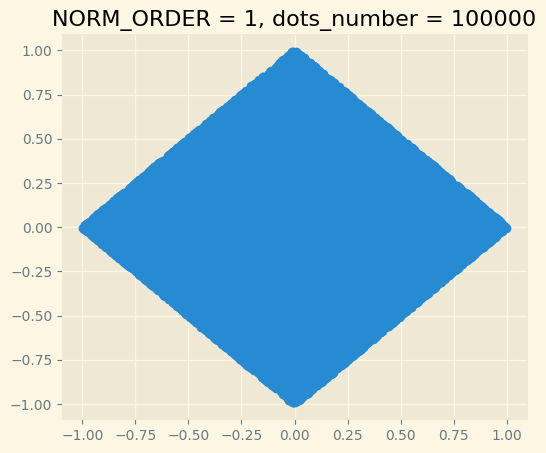

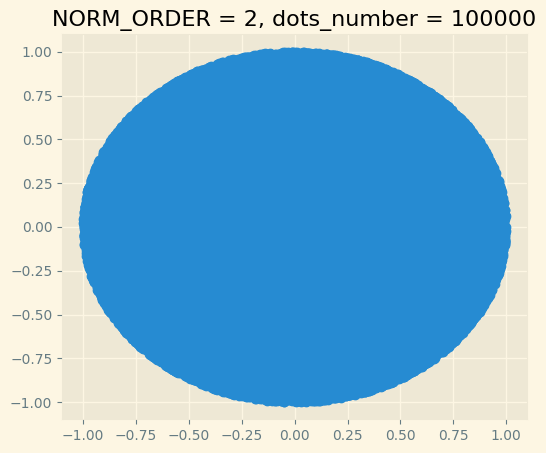

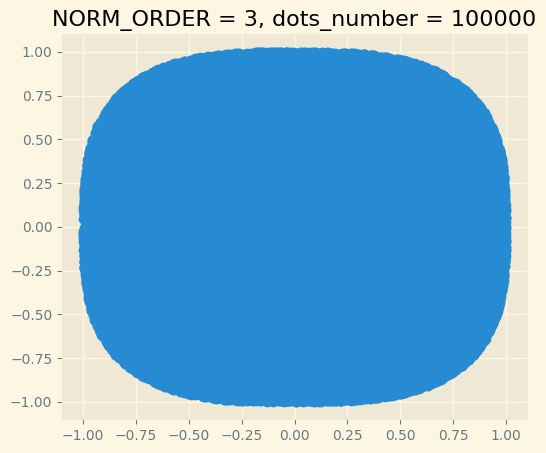

In [11]:
def plot_set(sim_number: int, order: int):
    sim_set = np.random.uniform(-1.0, 1.0, sim_number*2)
    deletes = list()
    for i in np.arange(0, sim_number*2, 2):
        if np.linalg.norm(sim_set[i:i+2], ord=order) > 1:
            deletes.append(i)
            deletes.append(i+1)
    sim_set = np.delete(sim_set, deletes, None)

    plt.figure(figsize=(6,5))
    plt.scatter(sim_set[::2],sim_set[1::2])
    plt.title(f'NORM_ORDER = {order}, dots_number = {sim_number}')

plt.style.use('Solarize_Light2')
for order in (1,2,3):
    plot_set(10**5, order)

## Task 6
here starts copypaste part (from convolutions.ipynb)

In [12]:
c = 3
# Generate some data
np.random.seed(42)
lambda1 = np.random.normal(size=(c, c))
lambda2 = np.random.normal(size=(c, c))
lambda3 = np.random.normal(size=(c, c))
G1 = np.random.normal(size=(c, c, c))
G2 = np.random.normal(size=(c, c, c))
U = np.random.normal(size=(c, c, c, c))

In [13]:
def Z_naive(lambda1, lambda2, lambda3, G1, G2, U):
    c = lambda1.shape[0]
    Z = np.zeros(shape=(c, c, c, c))
    for a, b, c, d, e, f, g, h, i, j in itertools.product(*([range(c)]*10)):
        Z[a, h, i, j] += lambda1[a, b]*lambda2[d, e]*lambda3[g, h]*G1[c, b, d]*G2[f, e, g]*U[i, j, c, f]
    return Z

In [14]:
%%timeit
Z = Z_naive(lambda1, lambda2, lambda3, G1, G2, U)

58.4 ms ± 1.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
%%timeit
Z=np.einsum('ab, cbd, de, feg, gh, ijcf -> ahij',
            lambda1, G1, lambda2, G2, lambda3, U,
            optimize= 'greedy')

230 µs ± 5.76 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [16]:
information=np.einsum_path('ab, cbd, de, feg, gh, ijcf -> ahij',
                         lambda1, G1, lambda2, G2, lambda3, U,
                         optimize= 'greedy')
print(information[1])

  Complete contraction:  ab,cbd,de,feg,gh,ijcf->ahij
         Naive scaling:  10
     Optimized scaling:  6
      Naive FLOP count:  3.543e+05
  Optimized FLOP count:  2.431e+03
   Theoretical speedup:  145.740
  Largest intermediate:  8.100e+01 elements
--------------------------------------------------------------------------
scaling                  current                                remaining
--------------------------------------------------------------------------
   4                 cbd,ab->acd                 de,feg,gh,ijcf,acd->ahij
   4                 feg,de->dfg                    gh,ijcf,acd,dfg->ahij
   4                 dfg,gh->dfh                       ijcf,acd,dfh->ahij
   5               dfh,acd->acfh                          ijcf,acfh->ahij
   6             acfh,ijcf->ahij                               ahij->ahij


### $ minimal\ number\ of flops\ for\ Z\ computation\ is\ \lambda^6$

## Task 7
here starts copypaste part (from kmeans.ipynb)

In [17]:
N = 10000
K = 3
d = 3
L = 10
# Generate some data
np.random.seed(42)
mu_true = np.random.uniform(-L, L, size=(K, d))
data = np.random.normal(mu_true, size=(N, K, d))
data = np.vstack(data)
np.random.shuffle(data)

In [18]:
mu = data[np.random.choice(range(data.shape[0]), K, replace=False)]
c = np.random.randint(low=0, high=K-1, size=data.shape[0])

In [19]:
def dist_i(x, mu):
    # x: N datapoints, mu: N cluster centers
    # returns: D_{i}, squared distances from x[i] to mu[i]
    dist = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        dist[i] = np.sum((x[i] - mu[i])**2)
    return dist
def dist_ij(x, mu):
    # x: N datapoints, mu: K cluster centers
    # returns: D_{ij}, squared distances from x[i] to mu[j]
    dist = np.zeros((x.shape[0], mu.shape[0]))
    for i in range(x.shape[0]):
        for j in range(mu.shape[0]):
            dist[i, j] += np.sum((x[i] - mu[j])**2)
    return dist

In [20]:
#default performance
ss_list = []
t=time.time()
for n in range(10):
    c =  np.argmin(dist_ij(data, mu), axis = 1)
    ss = np.mean(dist_i(data, mu[c]))
    ss_list.append(ss)
    for i in range(K):
        cluster_members = data[c == i]
        cluster_members = cluster_members.mean(axis = 0)
        mu[i] = cluster_members
print(time.time()-t)

5.315915107727051


In [21]:
def fast_dist_i(x, mu):
    dist = np.sum(np.square(x - mu),axis=1)
    return dist

def fast_dist_ij(x, mu):
    x_new=np.reshape(x,(N*K,1,3))
    x_new=np.repeat(x_new,K,axis=1)
    mu_new=np.reshape(mu,(1,K,3))
    mu_new=np.repeat(mu_new,N*K,axis=0)
    dist=np.sum(np.square(x_new-mu_new),axis=2)
    return dist

In [22]:
# new functions performance
ss_list = []
t=time.time()
for n in range(10):
    c =  np.argmin(fast_dist_ij(data, mu), axis = 1)
    ss = np.mean(fast_dist_i(data, mu[c]))
    ss_list.append(ss)
    for i in range(K):
        cluster_members = data[c == i]
        cluster_members = cluster_members.mean(axis = 0)
        mu[i] = cluster_members
print(time.time()-t)

0.054204702377319336


## Task 8

In [23]:
def sequence1(number: int):
    prealloc = np.empty(number, dtype=int)
    prealloc[0] = 1
    prealloc[1] = 1
    for i in np.arange(2,number):
        new_ind = prealloc[i-1]
        prealloc[i] = prealloc[new_ind] + prealloc[i-new_ind]

def sequence2(number: int):
    array = [1,1]
    i = 2
    while i < number:
        new_ind = array[-1]
        array.append(array[new_ind] + array[i-new_ind])
        i+=1
    np.array(array)

@nb.jit()
def sequence3(number: int):
    prealloc = np.empty(number, dtype=int)
    prealloc[0] = 1
    prealloc[1] = 1
    for i in np.arange(2,number):
        new_ind = prealloc[i-1]
        prealloc[i] = prealloc[new_ind] + prealloc[i-new_ind]
    return prealloc[-1]

N = 100

In [24]:
%timeit sequence1(N)

35.8 µs ± 1.46 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [25]:
%timeit sequence2(N)

14.9 µs ± 260 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [28]:
sequence3(N) # call for not counting time of compilation
%timeit sequence3(N)

2.19 µs ± 269 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [29]:
t = time.time()
elem = sequence3(10**8)
t = time.time() - t

print(t)
print(elem)

0.5509028434753418
99999999
